In [1]:
from comet_ml import Experiment
import numpy as np
import os
import sys


DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)
from features.tidy_data import tidy_data
from visualizations.simple_visualization import *
from feature_eng1 import *

In [2]:
# with open('../../COMET_API_KEY.txt', 'r') as f:
#     my_key = f.read()

# experiment = Experiment(
#   api_key=my_key,
#   project_name="nhl-project-b10",
#   workspace="ift6758b-project-b10"
# )

### We split the data into training, validation and test sets:

#### Train set(including validation set): 2016/2017-2019/2020
#### Test set : 2020/2021

## Question 1

In [3]:
train_df = generate_train_set(DATA_PATH)
train_df

,game_id,homeTeam,awayTeam,periodType,period,periodTime,team,eventType,x_coordinate,y_coordinate,goal_location,shooter,goalie,shotType,emptyNet,strength,shotAngle,shotDistance,is_goal
0,2016020380,WSH,BUF,REGULAR,2,14:54,BUF,Shot,-75.0,-2.0,Left,Jake McCabe,Braden Holtby,Wrist Shot,0,None,8.130102,14.142136,0
1,2017020239,CGY,DET,REGULAR,3,12:33,DET,Shot,54.0,-18.0,Right,Dylan Larkin,Mike Smith,Wrist Shot,0,None,27.216112,39.357337,0
2,2019020909,VAN,ANA,REGULAR,1,05:38,ANA,Goal,35.0,-27.0,Right,Adam Henrique,Thatcher Demko,Wrist Shot,0,EVEN,26.565051,60.373835,1
3,2016020508,WSH,TBL,REGULAR,2,18:40,TBL,Shot,-59.0,-18.0,Left,Nikita Nesterov,Braden Holtby,Wrist Shot,0,None,30.963757,34.985711,0
4,2019030114,MTL,PHI,REGULAR,2,16:36,MTL,Shot,55.0,41.0,Right,Phillip Danault,Carter Hart,Wrist Shot,0,None,50.332159,53.263496,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,2016020040,MTL,PIT,REGULAR,2,17:57,MTL,Shot,52.0,33.0,Right,Max Pacioretty,Marc-Andre Fleury,Wrist Shot,0,None,41.729512,49.578221,0
327338,2017020551,CBJ,PHI,REGULAR,2,18:40,CBJ,Shot,-55.0,11.0,Right,Cam Atkinson,Brian Elliott,Slap Shot,0,None,4.368277,144.419528,0
327339,2019020070,DAL,WSH,REGULAR,3,03:58,DAL,Shot,-78.0,4.0,Left,Alexander Radulov,Ilya Samsonov,Tip-In,0,None,19.983107,11.704700,0
327340,2018020839,BUF,DET,REGULAR,3,05:49,DET,Shot,-39.0,-17.0,Right,Jacob de la Rose,Linus Ullmark,Wrist Shot,0,None,7.565321,129.123971,0


In [4]:
# save the train_df
# train_df.to_csv('train_df.csv', index=False)
# train_df = pd.read_csv('train_df.csv')
# train_df    

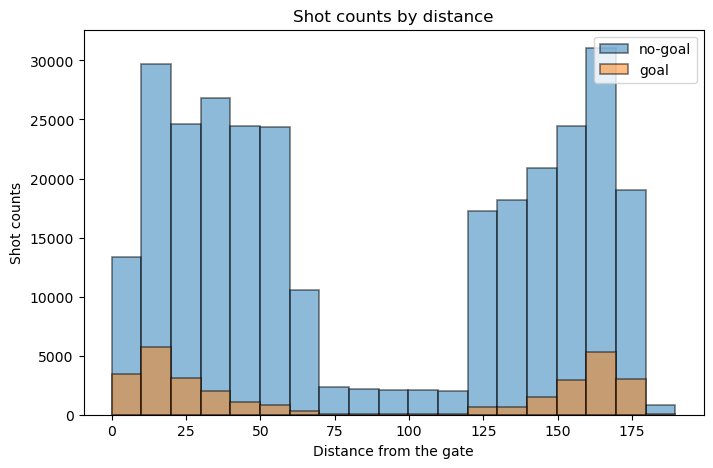

In [5]:
bin_by_distance(train_df)

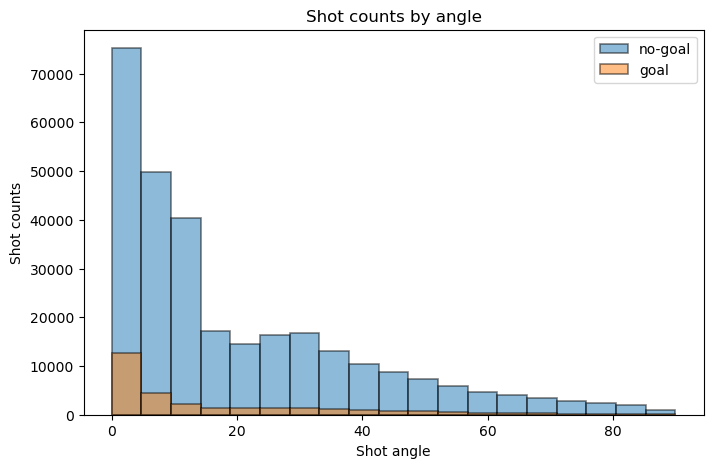

In [6]:
bin_by_angle(train_df)

<Figure size 800x500 with 0 Axes>

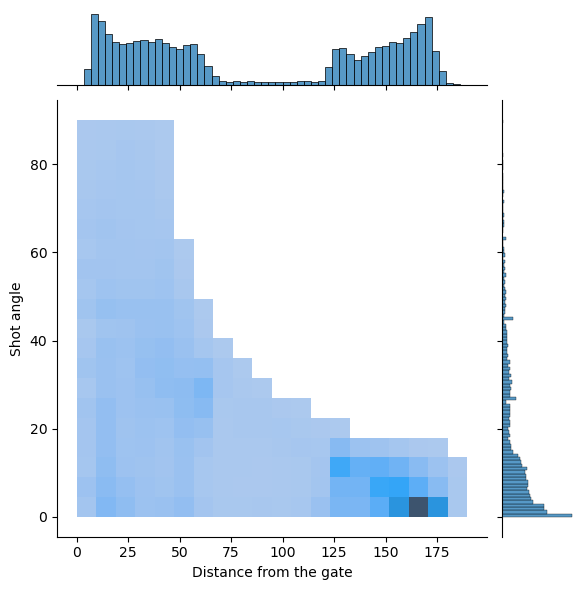

In [7]:
joint_plot(train_df)

## Question 2

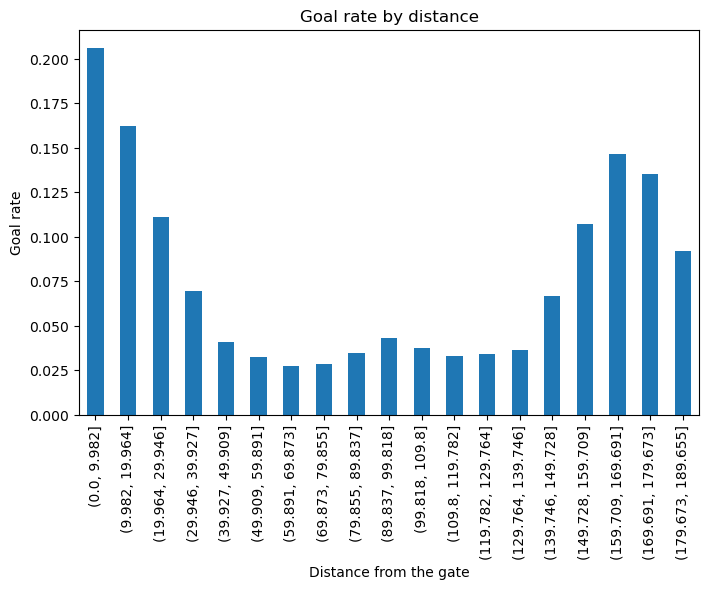

In [8]:
prob_by_distance(train_df)

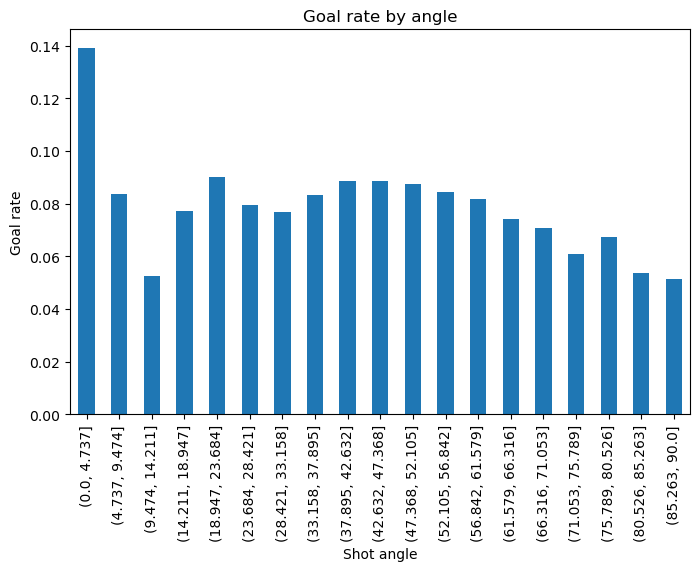

In [9]:
prob_by_angle(train_df)

## Question 3

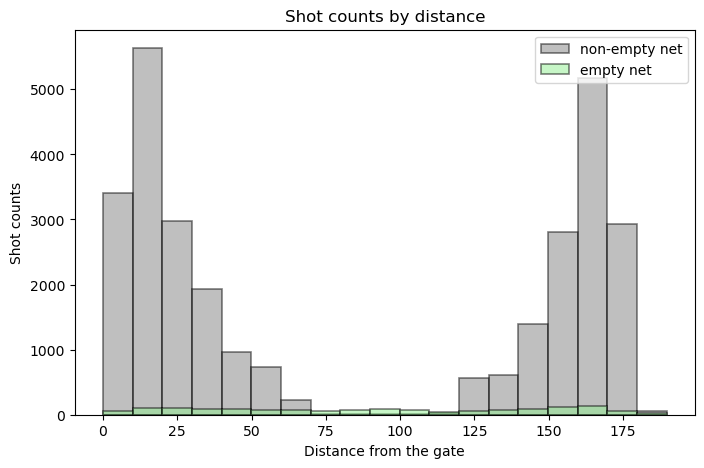

In [10]:
check_emptyNet(train_df)